# RL homework 1
**Due date: March 2nd, 2021, 11am**

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

Name: Daniel May

Student number: 18144954

**How to submit**

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`studentnumber_RL_hw1.ipynb`** before the deadline above.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms (without running experiments or extensive calculations)

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [ ]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [ ]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [ ]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [ ]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#009988', '#0033ff', '#993388', '#ee6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=50,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [ ]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1
**[8 pts]** Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [ ]:
class UCB(object):

  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.name = name
    self.bonus_multiplier = bonus_multiplier
    self.reset()

  def step(self, previous_action, reward):

    # Update values
    if previous_action != None:
      self.N[previous_action] += 1
      self.Q[previous_action] += (1. / self.N[previous_action]) * (reward - self.Q[previous_action])
    self.t += 1

    # Get new action
    untried = np.argwhere(self.N == 0).flatten()
    if untried.size != 0:
      # Treat untried actions as maximizing
      action = np.random.choice(untried)
    else:
      # Choose UCB maximising action
      bounds = self.Q + self.bonus_multiplier * np.sqrt(np.log(self.t) / self.N)
      action = argmax(bounds)
    return action

  def reset(self):
    self.t = 0
    self.Q = np.zeros(self._number_of_arms)
    self.N = np.zeros(self._number_of_arms)

## Q2
**[8 pts]** Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [ ]:
class EpsilonGreedy(object):

  def __init__(self, name, number_of_arms, epsilon):
    self.name = name
    self._number_of_arms = number_of_arms
    self.epsilon = epsilon
    self.reset()

  def step(self, previous_action, reward):

    # Update values
    if previous_action != None:
      self.N[previous_action] += 1
      self.Q[previous_action] += (1. / self.N[previous_action]) * (reward - self.Q[previous_action])
    self.t += 1

    # Get new action
    epsilon = self.epsilon(self.t) if callable(self.epsilon) else self.epsilon
    if np.random.rand() < epsilon:
      # Explore
      action = np.random.randint(self._number_of_arms)
    else:
      # Exploit
      action = argmax(self.Q)

    return action      

  def reset(self):
    self.t = 0
    self.Q = np.zeros(self._number_of_arms)
    self.N = np.zeros(self._number_of_arms)

## Q3
**[12 pts]** Implement a softmax REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [ ]:
class REINFORCE(object):

  def __init__(self, name, number_of_arms, step_size, baseline):
    self._number_of_arms = number_of_arms
    self.name = name
    self.step_size = step_size
    self.baseline = baseline
    self.reset()

  def step(self, previous_action, reward):

    # Compute square-max probabilities
    action_probabilities = np.square(self.H) / np.sum(np.square(self.H))

    # Update values
    if previous_action != None:

      # Baseline update if applicable
      if self.baseline:
        # S&B (2.5)
        self.baseline_average_reward += self.step_size * (reward - self.baseline_average_reward)
        
      # Gradient update
      indicator = np.zeros_like(action_probabilities)
      indicator[previous_action] = 1
      if self.baseline:
        self.H = self.H + self.step_size * (reward - self.baseline_average_reward) * 2 * (indicator / self.H - action_probabilities / self.H)
      else:
        self.H = self.H + self.step_size * reward * 2 * (indicator / self.H - action_probabilities / self.H)

    self.t += 1
      
    # Get new action
    action = np.random.choice(np.arange(self._number_of_arms), p=action_probabilities)

    return action

  def reset(self):
    self.baseline_average_reward = 0
    self.t = 0
    self.H = np.ones(self._number_of_arms)

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [ ]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE without baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

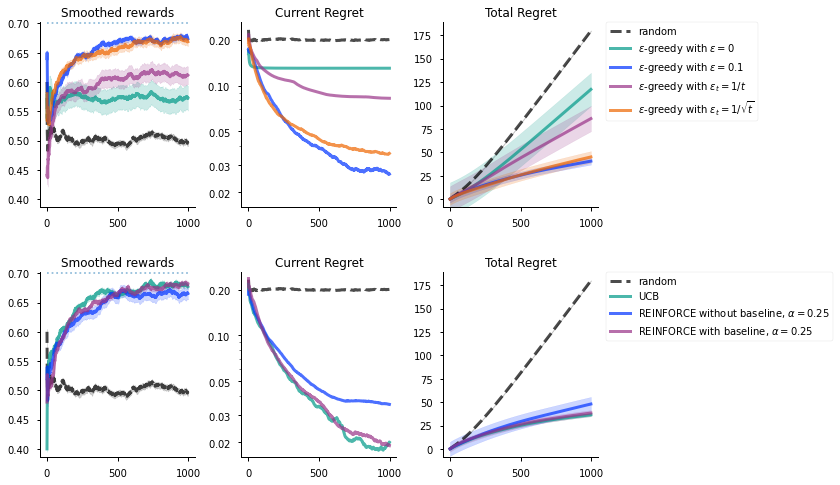

In [ ]:
experiment1.show()

## Q5
(Answer inline in the markdown below each question, **within this text cell**.)

**[5pts]** For the best two algorithms from the above plots, explain whether
we would in general expect this algorithm to do well, and why.

> UCB and the $\epsilon$-greedy algorithm with $\epsilon_t=1/\sqrt{t}$ seem to be the best two algorithms, as their total regrets are the lowest by the final step, and we can see they are consistently achieving very good rewards by the end.
>
> Both UCB and $\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$ explore well in the beginning, and the amount of exploration decays over time, which allows them to find the best action, then exploit it more and more as they become more certain (UCB) or rate of exploration ($\epsilon$-greedy) decays.
>
> It is therefore unsurprising that they perform well, with their sample-average reward estimates, in stationary settings like in Experiment 1, but due to the decrease in exploration over time, we would not expect them to do well in non-stationary settings.

**[5pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms.

> The ranking of the $\epsilon$-greedy algorithms seems unsurprising:
>
> With $\epsilon=0$, the algorithm will try each of the arms randomly until the first success, at which point it will repeatedly exploit this arm thereafter, which is unlikely to be the optimal one. It therefore performs worst, and only tends to be slightly better than random.
>
> $\epsilon_t=1/t$ improves quickly at the very beginning, but the decrease in exploration ($\epsilon$) is thereafter too fast, so it exploits much more than the better performing algorithms (with $\epsilon=0.1$ and $\epsilon_t=1/\sqrt{t}$) do before it has found a more optimal solution.
>
> $\epsilon=0.1$ explores much more, and is only outperformed by $\epsilon_t=1/\sqrt{t}$. This would likely be because $\epsilon=0.1$ is needlessly exploring 10\% of the time having found a near-optimal solution to exploit.
>
> As mentioned, $\epsilon_t=1/\sqrt{t}$ performs the best. This is likely to be because $\epsilon$ decreases slowly enough that it explores enough to find a near-optimal solution, and the gradual decrease allows it to exploit this solution much more often than $\epsilon=0.1$ (after $t=100$, $\epsilon$ will be less than $0.1$ and decreasing).

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [ ]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

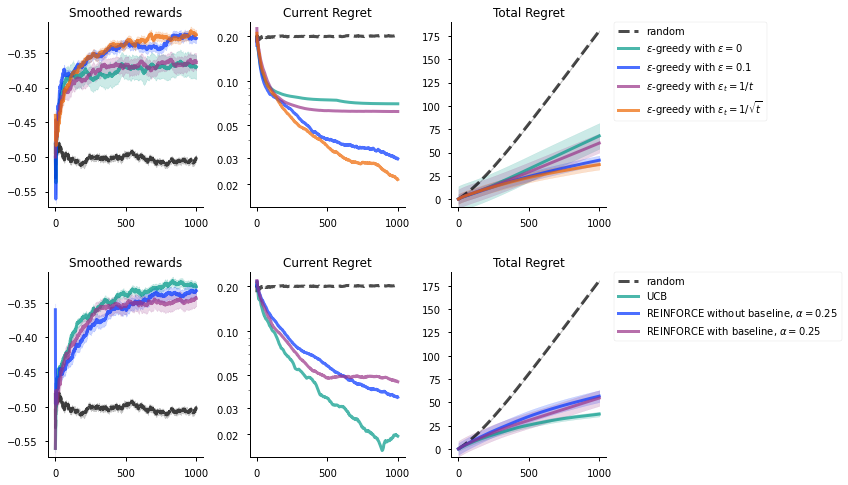

In [ ]:
experiment2.show()

## Q6
**[8pts]** For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

* The $\epsilon$-greedy algorithm with $\epsilon=0$ changed significantly; as the success reward is now 0 and the initial reward estimates are all 0, the algorithm is biased to be more optimistic. If an arm results in a failure, it will try an untried arm, and so on until each arm has been tried (unlike in Experiment 1), and thereafter it can exploit from the arms that were successful and then failed initially, and can explore somewhat within this set as it gets more accurate value estimates.

* $\epsilon=0.1$ did not change significantly; as the amount of exploration is already relatively high, the optimistic initial values did not change much in the medium-to-long run. However, the optimism does seem to have helped it explore and find a better solution more quickly in the first 100 steps or so, so was significant in that sense.

* $\epsilon_t=1/t$ changed significantly; as $\epsilon_t$ and therefore the amount of exploration decreases relatively quickly, the optimistic initial values helped to provide some prior knowledge which encouraged more exploration early on than in Experiment 1, and it more often converges to a solution with a higher reward and lower total regret as a result.

* $\epsilon_t=1/\sqrt{t}$ did not change significantly; in the medium-to-long run, like with $\epsilon=0.1$ the algorithm explored enough that it can find a very good solution. The optimism was not as impactful as for $\epsilon=0.1$ as $\epsilon_t=1/\sqrt{t}$ already explored often in the beginning in experiment 1.

* UCB did not change significantly; UCB always begins by trying each of the untried actions, and therefore quickly removes the optimistic bias of the initial estimates when computing the sample-averages for each actions.

* REINFORCE without baseline did not change significantly; in REINFORCE, we do not estimate the values of the rewards, and instead update our preferences for the individual actions based on samples.

* REINFORCE with baseline did not change significantly; we would expect the baseline (in our case, the average of the rewards) to adapt to the level of the rewards in Experiment 2 just as they did in Experiment 1, and it is learning preferences rather than estimating the values of the rewards.

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [ ]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [ ]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

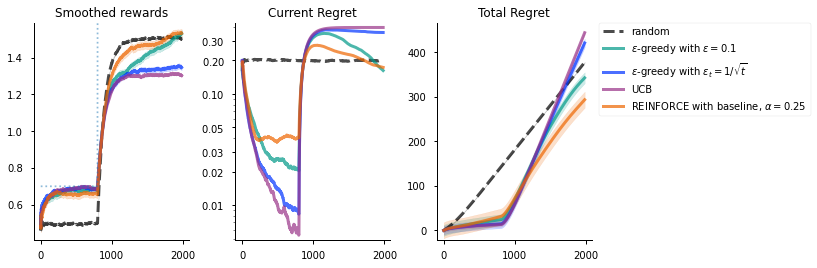

In [ ]:
experiment3.show()

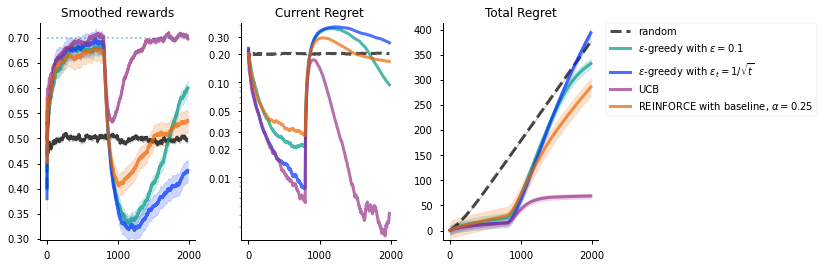

In [ ]:
experiment4.show()

## Q7

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

**[8 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> The REINFORCE with baseline algorithm adapts fastest, as seen by its current and total regret, to the non-stationary setting, as it weighs recent actions and rewards exponentially more then past actions when updating its baseline and policy, allowing it to adapt to the new setting. The $\epsilon$-greedy algorithm with $\epsilon=0.1$ also succeeds in adapting, but slightly more slowly (needing more steps), as it weighs rewards from the first setting equally to the new setting, and $\epsilon_t=1/\sqrt{t}$ adapts much more slowly as $1/sqrt(800) \approx 1/28 \approx 0.035$ means it is exploring relatively little by 800 steps. As UCB had high certainty in the arm it should exploit by 800 steps, and the expected reward of the arm at the change-point only increased, it continues to pursue the same strategy, with greater regret than choosing at random.

**[8 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> UCB now adapts fastest to the new setting, as seen by its smoothed rewards and regrets, since the reward estimate for the arm it tended to exploit in the first setting can and does now go down, and as the number of times it has tried the arm will be large by 800 steps, this combined with the uncertainty bounds enable it to begin to explore other options quickly. Similarly, the exponential recently-weighted averaging and the baseline term in REINFORCE allows the algorithm to adapt, and its preference for the solution before step 800 will reduce since it no longer gives such a high an average reward, until it will eventually find the new optimal solution. The epsilon-greedy with $\epsilon=0.1$ algorithm still adapts slowly due to its use of sample-average reward estimates, and $\epsilon_t=1/\sqrt{t}$ can now adapt, since by expoiting the arm found by step 800 often, it will update its sample-average reward estimate of the arm downwards, allowing it to explore other options.

**[4 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> In experiment 3, UCB was highly certain in its solution by 800 steps, and the expected reward for this solution only *increased* after the change-point, so its reward estimate for the arm increased and it had even less interest in exploring other options (they may need an even greater uncertainty bound), and continued pursuing about the same strategy as before. By contrast, in experiment 4 the sample-average estimated reward for the best arm found by 800 went *down*, and as it had exploited this arm a large number of times, this combined with the uncertainty in the other arms allowed it to explore the other actions, and tend towards a good solution extremely quickly.

**[4 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify the $\epsilon$-greedy algorithm implemented above to deal with that better?  Be specific and concise.

> Some ways are to use a constant step-size parameter for updating the reward estimates, which puts more weight on recent rewards, rather than using a sample-average estimate, and to use an $\epsilon$ value that does not decay over time, so that the algorithm continues to explore. Using an exponential recently-weighted average for the former, the reward estimate update becomes
$ Q_{k+1} = Q_k + \alpha \left[ R_k - Q_k \right] = (1 - \alpha)^k Q_1 + \sum_{i=1}^k \alpha (1 - \alpha)^{k-i} R_i $, where the weight given to past rewards decays with $(1 - \alpha)$'s exponent. Additionally, there exist other modifications to $\epsilon$-greedy algorithms which detect change-points to adapt to non-stationary settings.

**[8 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> A number of modifications to UCB have been proposed for the non-stationary setting, including *discounted* and *sliding-window* UCB, which are closely related, and allow for more exploration as time goes on than classic UCB, by placing less weight and confidence in past rewards. Discounted UCB uses a discount factor $\gamma \in (0, 1)$ to track its reward estimates, giving more weight to recent rewards in its estimates, and it also places more confidence in recent rewards, replacing the action count in its uncertainty term with a count that discounts past actions exponentially with $\gamma$. Sliding-window UCB works similarly, but only considers the last $\tau$ actions, as opposed to all of them.

# C) Reasoning about algorithms

## Q8

Consider the UCB algorithm. Suppose we have two actions, $a$ and $b$. Consider the initial exploration bonus for each to be infinite, as long as we have not selected the corresponding action, so that the algorithm first selects each action at least once.

Suppose action $a$ yields a Bernoulli random reward with $p(R=1 \mid a) = 1/3$ and $p(R=0 \mid a) = 2/3$.  Action $b$ also yields a Bernoulli random reward, but with $p(R=1 \mid b) = 2/3$ and $p(R=0 \mid b) = 1/3$.

**[7 pts]** What is the probability (before seeing any data) of selecting action $a$ on the third time step (at which point we will have selected both $a$ and $b$ exactly once)?  (Break ties uniformly, if relevant.)

> UCB selects an action $A_t$ by $A_t = argmax_a \left[ \; Q_t(a) + c \sqrt{\dfrac{\ln t}{N_t(a)}} \; \right]$.
> 
> As the algorithm will have selected each action once, the $c \sqrt{\dfrac{\ln t}{N_t(a)}}$ term will equal $c \sqrt{\dfrac{\ln 3}{1}}$ on the third time step for each action, and therefore be irrelevant to the argmax.
>
> Therefore, the action on the third time step will be determined by the estimated rewards, with $A_3 = argmax_a \left[ \; Q_3(a) \; \right]$.
>
> As each action will have been selected once, we can list the possible rewards up to this point and their probabilities:
>
> * $p(R = 0 | a) p(R = 0 | b) = 2/3 * 1/3 = 2/9$, which implies each action will be chosen with probability $1/9$ on the third time step, as the estimated rewards are equal.
> * $p(R = 1 | a) p(R = 0 | b) = 1/3 * 1/3 = 1/9$, which implies $a$ will be chosen with probability $1/9$, as its estimated reward will be highest.
> * $p(R = 0 | a) p(R = 1 | b) = 2/3 * 2/3 = 4/9$, which implies $b$ will be chosen with probability $4/9$.
> * $p(R = 1 | a) p(R = 1 | b) = 1/3 * 2/3 = 2/9$, which implies each action will be chosen with probability $1/9$.
>
> Therefore, the probability of selecting $a$ on the third time step is $ P(A_3 = a) = 1/9 + 1/9 + 1/9 = 3/9 = 1/3 $.

## Q9

Consider a bandit with two arms, $a$ and $b$.  So far, we have seen the following actions and rewards, on time steps $t=1$ and $t=2$:
\begin{align*}
t=1\,:\qquad A_1=a~,~ R_1=0\\
t=2\,:\qquad A_2=b~,~ R_2=1 
\end{align*}
The rewards are known to be Bernoulli random variables (so $R_t \in \{0, 1\}$) with unknown means.

Consider a Thompson sampling algorithm to select actions, with a uniform Beta prior at time $t=0$ such that the probability density functions for the expected reward for both actions before seeing any data (at time $t=0$) are defined by $p(E[R] = x\mid a) = 1$, for all $x\in[0,1]$, and all $a$.


**[7 pts]** What is the probability under Thompson sampling of $A_3 = a$? Show your calculations, but keep it concise.

> Initally, the reward distributions are $R_a \sim \text{Beta}(1, 1)$ for action $a$ and $R_b \sim \text{Beta}(1, 1)$ for action $b$. After time steps $1$ and $2$, the posterior distributions are:
>
>\begin{align*}
\text{After }t=1:\; R_a \sim \text{Beta}(1, 2) \text{ and } R_b \sim \text{Beta}(1, 1) \\
\text{After }t=2:\; R_a \sim \text{Beta}(1, 2) \text{ and } R_b \sim \text{Beta}(2, 1) \\
\end{align*}
>
> We can then calculate $P(R_a > R_b)$ to give the probability of selecting action $a$ on the third time step.
>
>\begin{align*}
P(R_a > R_b) &= \int_0^1 \int_0^1 P(R_a = r_a) P(R_b = r_b) I(r_a > r_b) \, db \, da \\
&= \int_0^1 \int_0^{r_a} P(R_a = r_a) P(R_b = r_b) \, db \, da \\
&= \int_0^1 \int_0^{r_a} 4 (1 - r_a) r_b \, db \, da \; \text{ (by substituting in the PDFs)} \\
&= \dfrac{1}{6}
\end{align*}
>
> The probability of $A_3 = a$ is therefore $\dfrac{1}{6}$.

## Q10

Consider a tabular ergodic MDP, and consider the following algorithm: 

On each time step $t$ we use UCB in the state we are currently in to determine the action to take.  Specifically, use and update the required statistics for UCB locally, for that state. In other words, in each state we update the UCB statistics as if that state is a bandit problem. 

However, instead of averaging the immediate rewards to use as action values, we use one-step Q-learning with a step size $\alpha_t$ to predict action values with some discount $\gamma \in [0, 1]$.

**[8 pts]** Is this algorithm guaranteed to converge to the optimal value function $q_*$ (for any finite MDP with well-defined values, e.g., $\gamma<1$) for an appropriately chosen step size schedule $\{ \alpha_t \}_{t=0}^\infty$?  Prove your answer, but be concise.  (E.g., this proof should not include lengthy calculations, you don't have to specify a concrete step size schedule, etc.)

> In this scenario the algorithm is guaranteed to converge to the optimal value function $q_*$. We can see this by citing the theorem for Q-learning which states that Q-learning control converges to the optimal action-value function, $q \rightarrow q_*$, as long as we take each action in each state infinity often (as in slide 25 of Lecture 6: Model-free control). UCB matches this criteria, as the uncertainty in each action for each state continues to grow over time when it is not selected, so each would eventually have an upper confidence bound that ensured it was selected infinitely often. As a result, this algorithm would converge.